# Lab 2

### Ucitavanje podataka
Kreira .csv datoteku za svaki match

In [2]:
import os
import json
import pandas as pd
from sklearn import metrics as mts
import seaborn as sns
import matplotlib.pyplot as plt


imu_folders = ["imu_head.csv","imu_chair_back.csv","imu_chair_seat.csv","imu_right_hand.csv","imu_left_hand.csv"]
folders = ["keyboard.csv","mouse.csv","spo2.csv","heart_rate.csv","facial_skin_temperature.csv","eye_tracker"]

matches_folder = "matches"

for match_folder in os.listdir(matches_folder):
    if match_folder in[".DS_Store","all_data.csv"]:
        continue

    with open(os.path.join(matches_folder, match_folder, "meta_info.json")) as f:
        team_type = json.load(f)["team"]

    player_dfs = []
    
    for player_folder in os.listdir(os.path.join(matches_folder, match_folder)):
        if player_folder in ["meta_info.json", "environment.csv", "replay.json",".DS_Store","final.csv","merged_data.csv","all_data.csv"]:
            continue
        
        sensor_dfs = []
        
        for csv_file in os.listdir(os.path.join(matches_folder, match_folder, player_folder)):
            if csv_file.endswith(".csv") and csv_file in imu_folders:
                df = pd.read_csv(os.path.join(matches_folder, match_folder, player_folder, csv_file))
                df = df.filter(regex='^(gyro|linaccel|time)')

                df.rename(columns={'gyro_x': "gyro_x"+csv_file[0:-4], 'gyro_y': "gyro_y"+csv_file[0:-4],
                'gyro_z': "gyro_z"+csv_file[0:-4],'linaccel_x': "linaccel_x"+csv_file[0:-4],'linaccel_y': "linaccel_y"+csv_file[0:-4],
                'linaccel_z': "linaccel_z"+csv_file[0:-4],}, inplace=True)   

                sensor_dfs.append(df)
            
            if csv_file.endswith(".csv") and csv_file in folders:
                df = pd.read_csv(os.path.join(matches_folder, match_folder, player_folder, csv_file))
              
                sensor_dfs.append(df)
        
        player_df = pd.merge(sensor_dfs[0], sensor_dfs[1], on="time")
        for i in range(2, len(sensor_dfs)):
            player_df = pd.merge(player_df, sensor_dfs[i], on="time")
        
        player_dfs.append(player_df)
    

    match_df = pd.concat(player_dfs, axis=0)
    match_df["team_info"] = team_type
    match_df.to_csv(os.path.join(matches_folder, match_folder, "merged_data.csv"), index=False)

print("!")

Finished!


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


dfs = []
for match_folder in os.listdir(matches_folder):
    if match_folder in[".DS_Store","all_data.csv"]:
        continue
    df = pd.read_csv(os.path.join(matches_folder, match_folder, "merged_data.csv"))
    dfs.append(df)

df = pd.concat(dfs, axis=0)
df.to_csv(os.path.join(matches_folder, "all_data.csv"), index=False)


y = df["team_info"]
X = df.drop(columns=["team_info","time"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.66, random_state=42)


### Random Forest

Test accuracy(Random Forrest): 1.00


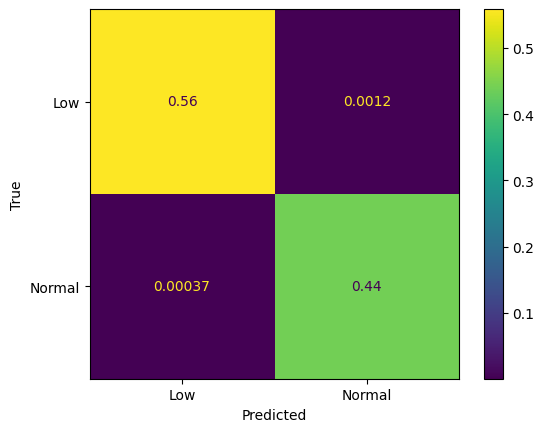

In [4]:
imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

model = RandomForestClassifier()
rfModel = model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Test accuracy(Random Forrest): {accuracy:.2f}")

cm = mts.confusion_matrix(y_test, rfModel.predict(X_test), normalize='all')
cmd = mts.ConfusionMatrixDisplay(cm, display_labels=['Low','Normal'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

fig = cmd.ax_.get_figure() 

plt.show()

#### Scaler za SVM i LR

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### SVM

Test accuracy(SVM): 0.7584313986954251


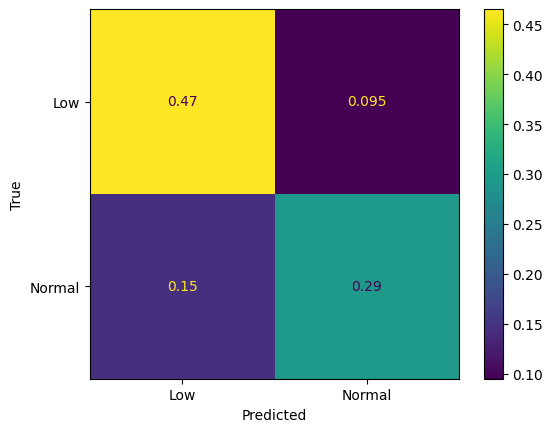

In [6]:
svm = SVC(kernel='linear', C=1.0)

svmModel = svm.fit(X_train, y_train)

accuracy = svm.score(X_test, y_test)
print('Test accuracy(SVM):', accuracy)

cm = mts.confusion_matrix(y_test, svmModel.predict(X_test), normalize='all')
cmd = mts.ConfusionMatrixDisplay(cm, display_labels=['Low','Normal'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

fig = cmd.ax_.get_figure() 

plt.show()

### Logisticka regresija

Test accuracy: 0.7559311486704225


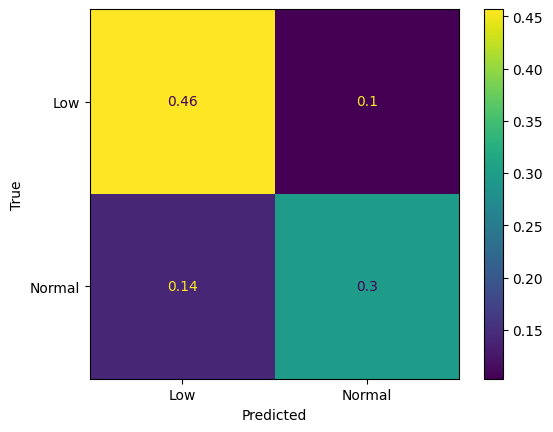

In [7]:
lr = LogisticRegression(C=1.0, solver='lbfgs')

lrModel = lr.fit(X_train, y_train)

accuracy = lr.score(X_test, y_test)
print('Test accuracy:', accuracy)

cm = mts.confusion_matrix(y_test, lrModel.predict(X_test), normalize='all')
cmd = mts.ConfusionMatrixDisplay(cm, display_labels=['Low','Normal'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

fig = cmd.ax_.get_figure() 

plt.show()